# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных
Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

import lightgbm as lgb
from catboost import CatBoostRegressor

from time import time
from tqdm import tqdm
import time
from sklearn.dummy import DummyRegressor

In [2]:
import os
print(os.getcwd())

file_path = 'autos.csv'
df = pd.read_csv(file_path)

C:\Users\lukia


In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Проверим и удалим дупликаты 

In [5]:
df.duplicated().sum()

4

In [6]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Проверим и пропуски

In [7]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
cols = df.isna().mean().sort_values(ascending=False).reset_index()
cols = cols[cols[0] > 0]
cols_with_missing = cols['index'].values
cols_with_missing

array(['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model'],
      dtype=object)

Данные колонки содержат категориальные признаки, поэтому пропуски заменим на ‘unknown’

In [9]:
df[cols_with_missing] = df[cols_with_missing].fillna('unknown')
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Удаление лишних колонок которые не понадобяться в обучении

В столбце NumberOfPictures все значения 0. Также, логически, следующие колонки: 'DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen' не имеют веса в обучении 

- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля (так как в столбце нет значений кроме 0)
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [10]:
df['NumberOfPictures'].unique()  

array([0], dtype=int64)

In [11]:
df = df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth'], axis = 1)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354360,0,unknown,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354361,2200,unknown,2005,unknown,0,unknown,20000,unknown,sonstige_autos,unknown
354362,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354363,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Ппроверим дупликаты после удаления замены пропусков и удаления лишних столбцов

In [12]:
df.duplicated().sum()

45036

In [13]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Посмотрим на графики числовых столбоцв и на выбросы

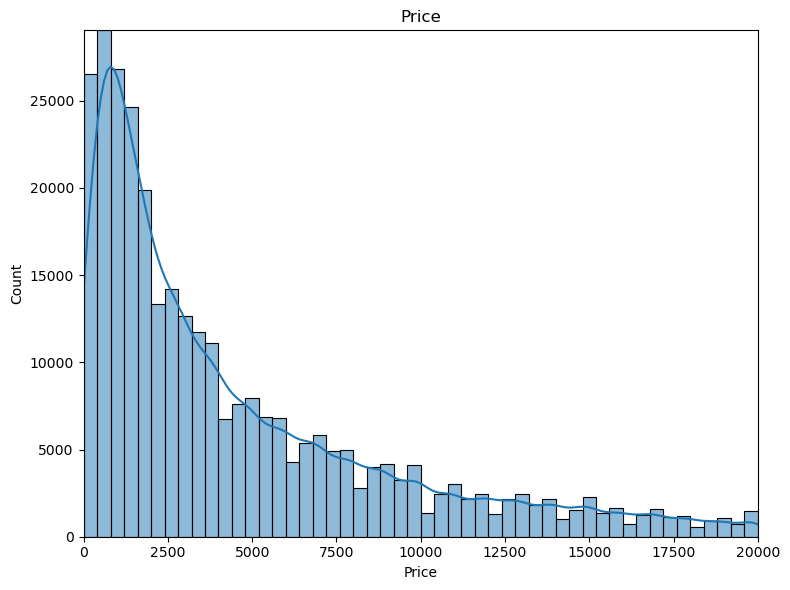

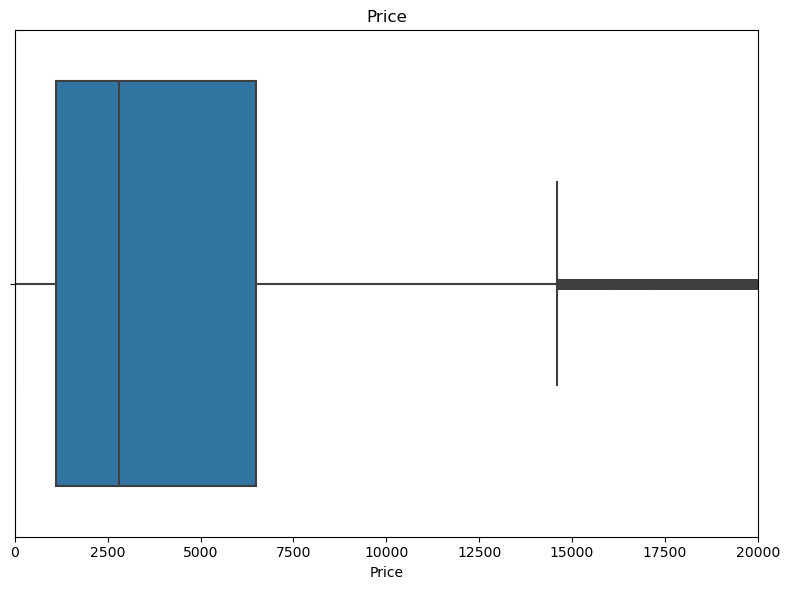

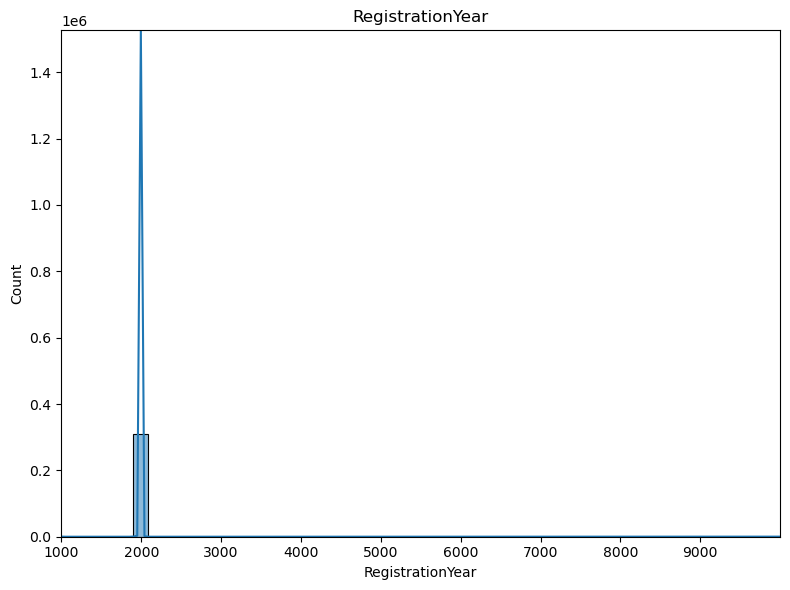

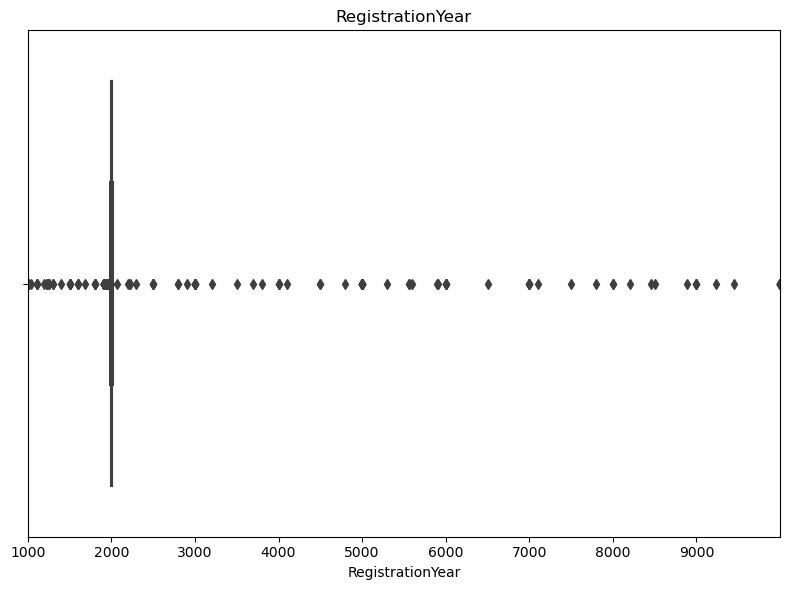

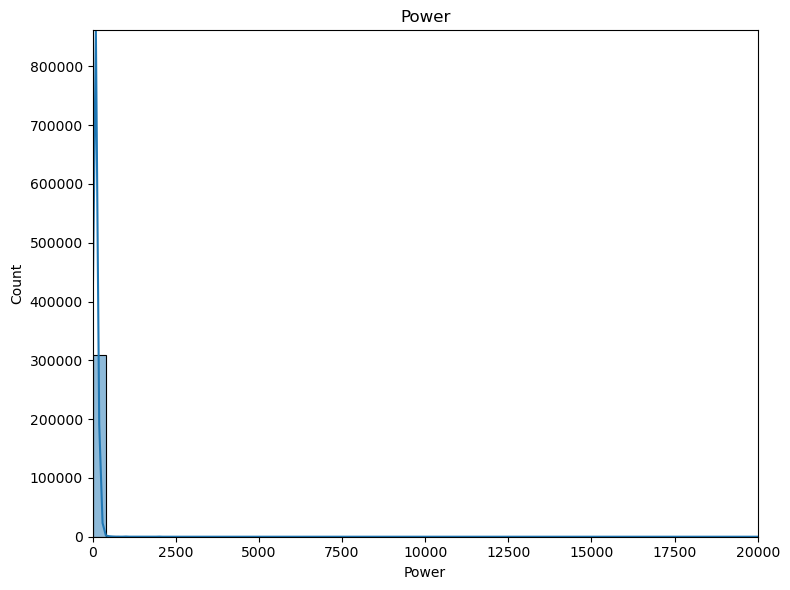

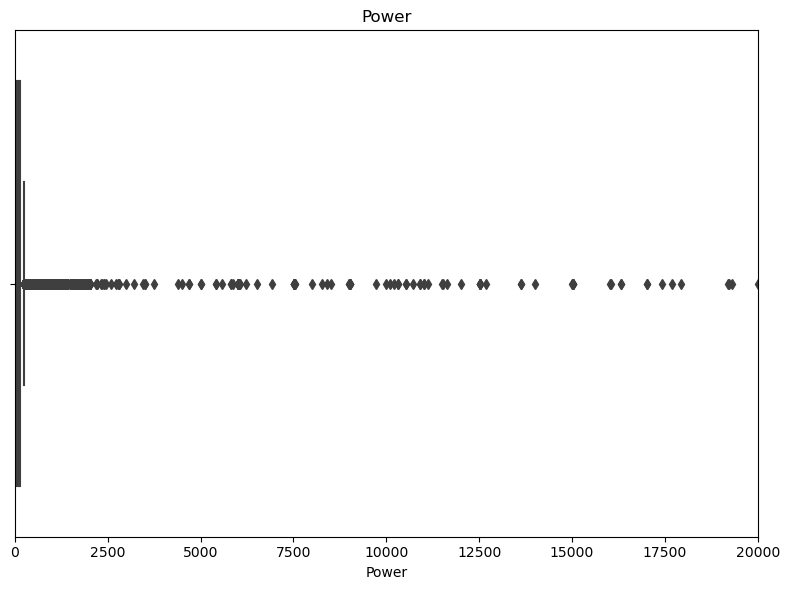

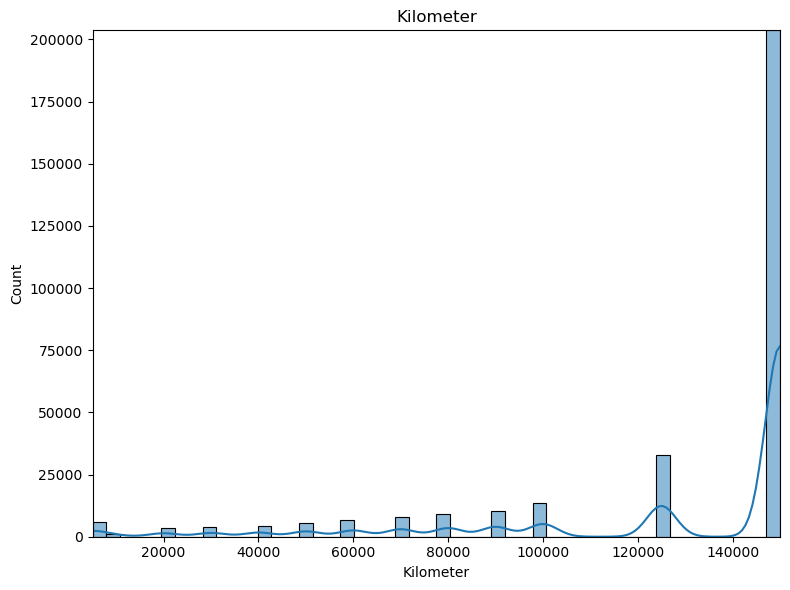

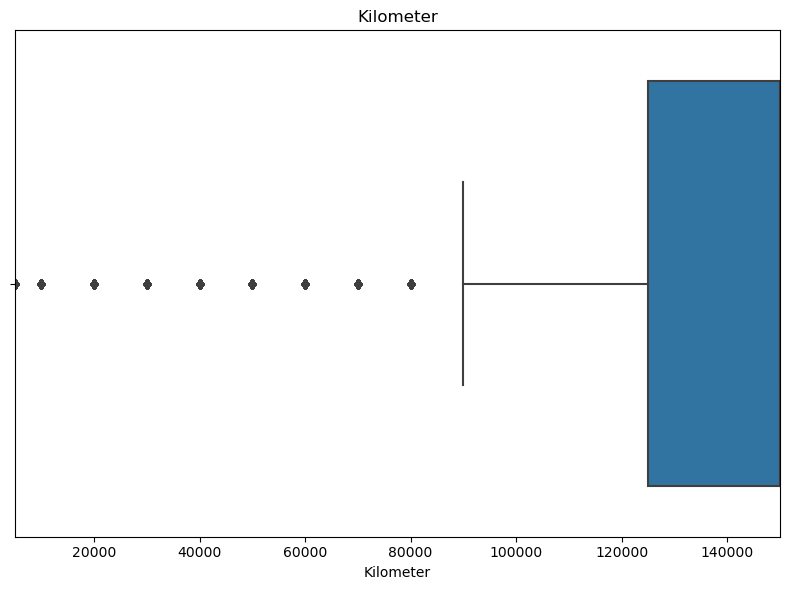

In [14]:
def plot_histogram(data, feature_name, bins=50, kde=True):
    plt.figure(figsize=(8, 6))
    sns.histplot(data[feature_name], bins=bins, kde=kde)
    plt.title(f'{feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Count')
    plt.autoscale(enable=True, axis='both', tight=True)
    plt.tight_layout()  
    plt.show()

def plot_boxplot(data, feature_name, title=None):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[feature_name])
    plt.title(f'{feature_name}')
    plt.xlabel(feature_name)
    plt.autoscale(enable=True, axis='both', tight=True)
    plt.tight_layout() 
    plt.show()
    
numeric_columns = df.select_dtypes(include=['int64']).columns

for column in numeric_columns:
    plot_histogram(df, column)
    plot_boxplot(df, column)

In [15]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Некоторые значения похожи на выбросы, например такие как:
- мощность, которая достигает у некоторых элементов безумных значений. Можно удалить все что меньше 1000 лошадиных сил и то что меньше 5 лошадиных сил.
- дата регистрации, например те машины, которым уже больше 100 лет, и те где года указаны больше сегодняшнего (2022)

In [16]:
df.query('Power >= 1000 | Power <= 5')


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
15,450,small,1910,unknown,0,ka,5000,petrol,ford,unknown
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no
37,1500,unknown,2016,unknown,0,kangoo,150000,gasoline,renault,no
40,0,unknown,1990,unknown,0,corsa,150000,petrol,opel,unknown
...,...,...,...,...,...,...,...,...,...,...
309306,180,unknown,1995,unknown,0,unknown,125000,petrol,opel,unknown
309312,2600,unknown,2005,auto,0,c_klasse,150000,unknown,mercedes_benz,unknown
309321,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no
309324,0,unknown,2005,manual,0,colt,150000,petrol,mitsubishi,yes


In [17]:
df.query('RegistrationYear < 1920 or RegistrationYear >= 2022')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
15,450,small,1910,unknown,0,ka,5000,petrol,ford,unknown
622,0,unknown,1111,unknown,0,unknown,5000,unknown,opel,unknown
6601,0,small,1910,unknown,0,unknown,5000,other,sonstige_autos,unknown
6943,135,unknown,1910,unknown,0,unknown,5000,unknown,opel,unknown
10110,1250,unknown,1910,unknown,0,other,5000,unknown,audi,unknown
...,...,...,...,...,...,...,...,...,...,...
299454,1,unknown,3000,unknown,0,zafira,5000,unknown,opel,unknown
300472,1,other,1910,unknown,0,unknown,5000,other,volkswagen,unknown
304992,1,unknown,1000,unknown,1000,unknown,150000,unknown,sonstige_autos,unknown
307202,11500,unknown,1800,unknown,16,other,5000,petrol,fiat,unknown


In [18]:
df = df.drop(df.query('Power >= 1000 | Power <= 5').index).reset_index(drop=True)

In [19]:
df = df.drop(df.query('RegistrationYear < 1920 or RegistrationYear >= 2016').index).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256402 entries, 0 to 256401
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             256402 non-null  int64 
 1   VehicleType       256402 non-null  object
 2   RegistrationYear  256402 non-null  int64 
 3   Gearbox           256402 non-null  object
 4   Power             256402 non-null  int64 
 5   Model             256402 non-null  object
 6   Kilometer         256402 non-null  int64 
 7   FuelType          256402 non-null  object
 8   Brand             256402 non-null  object
 9   Repaired          256402 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.6+ MB


Удаляем выбросы на основе стандартного отклонения

In [20]:
mean = df['Price'].mean()
std = df['Price'].std()
threshold = 3 * std

outliers = df.query('Price < (@mean - @threshold) or Price > (@mean + @threshold)')
df = df.drop(outliers.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253790 entries, 0 to 256401
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             253790 non-null  int64 
 1   VehicleType       253790 non-null  object
 2   RegistrationYear  253790 non-null  int64 
 3   Gearbox           253790 non-null  object
 4   Power             253790 non-null  int64 
 5   Model             253790 non-null  object
 6   Kilometer         253790 non-null  int64 
 7   FuelType          253790 non-null  object
 8   Brand             253790 non-null  object
 9   Repaired          253790 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.3+ MB


Проверим корреляцию

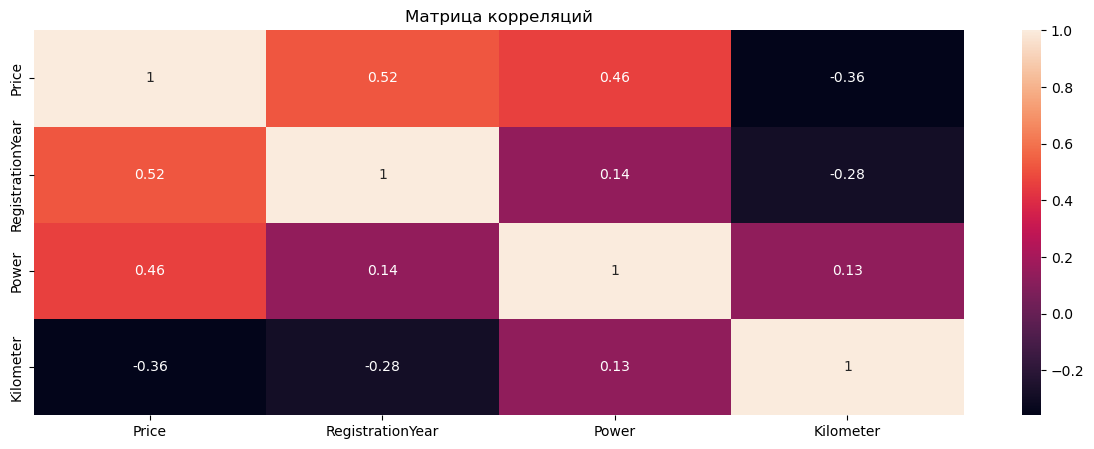

In [21]:
plt.figure(figsize=(15, 5))
plt.title('Матрица корреляций')

sns.heatmap(df.corr(), annot = True)

plt.show()

Эффекта мультиколлинеарности не наблюдается, т.к. нет значений приближенных к 1/-1. 

Деление на выборки, cтандартизация и маштабирование

In [23]:
features = df.drop('Price', axis=1)
target = df['Price']

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                              target,
                                                                              test_size = 0.2,
                                                                              random_state = 123)

print(f'Размер выборки train: {features_train.shape}, {target_train.shape}')
print(f'Размер выборки test: {features_test.shape}, {target_test.shape}')

Размер выборки train: (203032, 9), (203032,)
Размер выборки test: (50758, 9), (50758,)


In [24]:
scale_columns = np.array(features_train.select_dtypes(include=['int64', 'float64']).columns)
scaler = StandardScaler()
features_train_scaled = pd.DataFrame(scaler.fit_transform(features_train[scale_columns]), columns=scale_columns)
features_test_scaled = pd.DataFrame(scaler.transform(features_test[scale_columns]), columns=scale_columns)

cat_columns = np.array(features_train.select_dtypes(include=['object']).columns)
encoder = OrdinalEncoder()
features_train_encoded = pd.DataFrame(encoder.fit_transform(features_train[cat_columns]), columns=cat_columns)
features_test_encoded = pd.DataFrame(encoder.transform(features_test[cat_columns]), columns=cat_columns)

features_train_final = pd.concat([features_train_scaled, features_train_encoded], axis=1)
features_test_final = pd.concat([features_test_scaled, features_test_encoded], axis=1)

print(f'Размер выборки train: {features_train_final.shape}, {target_train.shape}')
print(f'Размер выборки test: {features_test_final.shape}, {target_test.shape}')

Размер выборки train: (203032, 9), (203032,)
Размер выборки test: (50758, 9), (50758,)


###### Итог:
- Проверили и удалили дупликаты в датафрейме
- Проверили и заполнили пропуски в категориальных данных
- Удалили выбросы в столбцах: 'RegistrationYear' и 'Power'
- Избавились от лишних признаков которые не понадобятся в машинном обучении
- Провелири датасет на мультиколлинеарность
- Провели прямое кодирование one-hot encoding

## Обучение моделей

###### RandomForest

In [25]:
start = time.time()

param_grid = {
    'n_estimators': range(10, 30, 10),
    'max_depth': range(1, 12, 2),
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=123),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           n_jobs=-1,
                           verbose=2
)

grid_search.fit(features_train_final, target_train)

end = time.time()
time_fit_rf_cv = end - start

best_params_rf = grid_search.best_params_
best_score_rf = (-grid_search.best_score_) ** 0.5

print('Train RMSE: {:.2f}'.format(best_score_rf))
print('Time: {:.2f}'.format(time_fit_rf_cv))
print('Best parameters:', grid_search.best_params_)

best_estimators_rf = grid_search.best_params_['n_estimators']
best_depth_rf = grid_search.best_params_['max_depth']

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Train RMSE: 1839.85
Time: 36.81
Best parameters: {'max_depth': 11, 'n_estimators': 20}


In [26]:
start = time.time()
model = RandomForestRegressor(n_estimators=best_estimators_rf, 
                              max_depth=best_depth_rf, 
                              random_state=123)

model.fit(features_train_final, target_train)

end = time.time()
time_fit_rf = end - start

start = time.time()
predictions_train = model.predict(features_train_final)
end = time.time()
time_pred_rf = end - start

print('Time Fit: {:.2f}'.format(time_fit_rf))
print('Time Predict: {:.2f}'.format(time_pred_rf))

Time Fit: 6.83
Time Predict: 0.47


###### LightGBM

In [27]:
start = time.time()
param_grid = {
    'boosting_type': ['gbdt'],
    'max_depth': range(1, 12, 2),
    'learning_rate': [0.01, 0.1, 0.15],
}

model = lgb.LGBMRegressor(random_state=123)

grid_search = GridSearchCV(model, 
                           param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(features_train_final, target_train)

end = time.time()
time_fit_lgbm_cv = end - start

best_params_lgbm = grid_search.best_params_
best_score_lgbm = (-grid_search.best_score_) ** 0.5

print('Best hyperparameters:', best_params_lgbm)
print('Best RMSE score:', best_score_lgbm)
print('Time: {:.2f}'.format(time_fit_lgbm_cv))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best hyperparameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15, 'max_depth': 11}
Best RMSE score: 1698.7629365320163
Time: 25.32


In [28]:
start = time.time()
model = lgb.LGBMRegressor(**best_params_lgbm, random_state=123)

model.fit(features_train_final, target_train)

end = time.time()
time_fit_lgbm = end - start

start = time.time()
predictions_train = model.predict(features_train_final)
end = time.time()
time_pred_lgbm = end - start

print('Time Fit: {:.2f}'.format(time_fit_lgbm))
print('Time Predict: {:.2f}'.format(time_pred_lgbm))

Time Fit: 1.35
Time Predict: 0.60


###### CatBoost

In [29]:
start = time.time()
param_grid = {
    'learning_rate': [0.01, 0.1, 0.15],
}

model = CatBoostRegressor(random_state=123)

grid_search = GridSearchCV(model,
                           param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(features_train_final, target_train)

end = time.time()
time_fit_cb_cv = end - start

best_params_cb = grid_search.best_params_
best_score_cb = (-grid_search.best_score_) ** 0.5

print('Best hyperparameters:', best_params_cb)
print('Best RMSE score:', best_score_cb)
print('Time: {:.2f}'.format(time_fit_cb_cv))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0:	learn: 4035.9368176	total: 163ms	remaining: 2m 42s
1:	learn: 3675.1161649	total: 193ms	remaining: 1m 36s
2:	learn: 3378.0072518	total: 224ms	remaining: 1m 14s
3:	learn: 3139.3802364	total: 255ms	remaining: 1m 3s
4:	learn: 2943.8035628	total: 272ms	remaining: 54.1s
5:	learn: 2783.1059065	total: 289ms	remaining: 47.9s
6:	learn: 2652.7661962	total: 302ms	remaining: 42.9s
7:	learn: 2545.0480114	total: 317ms	remaining: 39.2s
8:	learn: 2457.5702615	total: 331ms	remaining: 36.5s
9:	learn: 2382.8254781	total: 346ms	remaining: 34.2s
10:	learn: 2320.6963141	total: 360ms	remaining: 32.4s
11:	learn: 2270.5365897	total: 377ms	remaining: 31s
12:	learn: 2228.0996255	total: 394ms	remaining: 29.9s
13:	learn: 2191.1014110	total: 409ms	remaining: 28.8s
14:	learn: 2160.4628901	total: 424ms	remaining: 27.8s
15:	learn: 2126.5633500	total: 440ms	remaining: 27.1s
16:	learn: 2103.9485448	total: 453ms	remaining: 26.2s
17:	learn: 2081.2447543	total: 4

In [30]:
start = time.time()
model = CatBoostRegressor(**best_params_cb, random_state=123)

model.fit(features_train_final, target_train)
end = time.time()
time_fit_cb = end - start

start = time.time()
predictions_train = model.predict(features_train_final)
end = time.time()
time_pred_cb = end - start

print('Time Fit (CV): {:.2f}'.format(time_fit_cb))
print('Time Predict: {:.2f}'.format(time_pred_cb))

0:	learn: 4035.9368176	total: 25.2ms	remaining: 25.2s
1:	learn: 3675.1161649	total: 51.7ms	remaining: 25.8s
2:	learn: 3378.0072518	total: 75.1ms	remaining: 24.9s
3:	learn: 3139.3802364	total: 95.3ms	remaining: 23.7s
4:	learn: 2943.8035628	total: 111ms	remaining: 22.1s
5:	learn: 2783.1059065	total: 124ms	remaining: 20.6s
6:	learn: 2652.7661962	total: 137ms	remaining: 19.5s
7:	learn: 2545.0480114	total: 151ms	remaining: 18.7s
8:	learn: 2457.5702615	total: 165ms	remaining: 18.1s
9:	learn: 2382.8254781	total: 178ms	remaining: 17.7s
10:	learn: 2320.6963141	total: 193ms	remaining: 17.3s
11:	learn: 2270.5365897	total: 205ms	remaining: 16.9s
12:	learn: 2228.0996255	total: 221ms	remaining: 16.7s
13:	learn: 2191.1014110	total: 242ms	remaining: 17.1s
14:	learn: 2160.4628901	total: 257ms	remaining: 16.9s
15:	learn: 2126.5633500	total: 271ms	remaining: 16.7s
16:	learn: 2103.9485448	total: 285ms	remaining: 16.5s
17:	learn: 2081.2447543	total: 299ms	remaining: 16.3s
18:	learn: 2063.3657746	total: 312

Метрика слишком маленькая - 41, не понимаю где ошибка

## Анализ моделей

Анализ скорости и результата моделей на тренировочной выборке 

In [31]:
results = []
results.append({'Model': 'LightGBM', 'RMSE': best_score_lgbm, 'Time fit': time_fit_lgbm, 'Time pred': time_pred_lgbm})
results.append({'Model': 'CatBoost', 'RMSE': best_score_cb, 'Time fit': time_fit_cb, 'Time pred': time_pred_cb})
results.append({'Model': 'RandomForest', 'RMSE': best_score_rf, 'Time fit': time_fit_rf, 'Time pred': time_pred_rf})

df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by='RMSE', ignore_index=True)
display(df_results_sorted)

,Model,RMSE,Time fit,Time pred
0,CatBoost,1647.100650,17.741309,0.109793
1,LightGBM,1698.762937,1.346483,0.602206
2,RandomForest,1839.846819,6.829967,0.474072


- Лучшая модель по RMSE: CatBoost 

- Лучшая модель по скорости: LightGBM

- Выбираем лучшуб модель по RMSE-CatBoost

Проверяем лучшую модель на тестовый быборке 

In [32]:
best_model = CatBoostRegressor(**best_params_cb)
best_model.fit(features_train_final, target_train)   

predictions = best_model.predict(features_test_final)

mse = mean_squared_error(target_test, predictions)
rmse = np.sqrt(mse)

print('Test RMSE:', rmse)

0:	learn: 4023.3066747	total: 22.5ms	remaining: 22.5s
1:	learn: 3663.8350193	total: 48.7ms	remaining: 24.3s
2:	learn: 3379.0221777	total: 69ms	remaining: 22.9s
3:	learn: 3147.4678211	total: 86.9ms	remaining: 21.6s
4:	learn: 2947.7409955	total: 101ms	remaining: 20.1s
5:	learn: 2788.3310944	total: 116ms	remaining: 19.2s
6:	learn: 2658.5044207	total: 129ms	remaining: 18.3s
7:	learn: 2551.8320498	total: 142ms	remaining: 17.7s
8:	learn: 2462.5700832	total: 155ms	remaining: 17.1s
9:	learn: 2390.9273670	total: 168ms	remaining: 16.7s
10:	learn: 2324.7951164	total: 182ms	remaining: 16.4s
11:	learn: 2275.2351277	total: 195ms	remaining: 16.1s
12:	learn: 2231.0564547	total: 209ms	remaining: 15.9s
13:	learn: 2196.4003086	total: 222ms	remaining: 15.6s
14:	learn: 2167.1136319	total: 239ms	remaining: 15.7s
15:	learn: 2137.3120420	total: 255ms	remaining: 15.7s
16:	learn: 2116.2449260	total: 270ms	remaining: 15.6s
17:	learn: 2096.2422011	total: 283ms	remaining: 15.5s
18:	learn: 2077.9729465	total: 297ms

Сравниваем с константной моделью

In [33]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train_final, target_train)

predictions = dummy_model.predict(features_test_final)

rmse_dummy = mean_squared_error(target_test, predictions, squared=False)

print('Test RMSE:', rmse_dummy)

Test RMSE: 4449.668262952527


Наша модель все таки горазда лучше.